In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
#from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

sns.set(style='white',context='notebook',palette='deep')

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

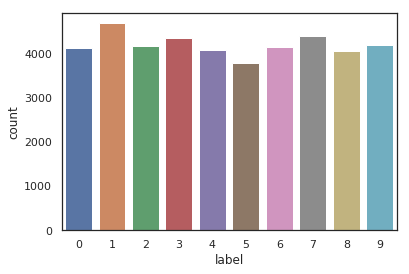

In [3]:
Y_train = pd.Series(train["label"]) 

X_train = train.drop(labels = ["label"],axis = 1)

g = sns.countplot(Y_train)

Y_train.value_counts()

全てのデータにおいて欠損値か欠損値でないかの２つの値にする
.any()
一個一個のデータに欠損か欠損でないか２つの値にする
.isnull()


In [4]:
X_train.any().describe()

count      784
unique       2
top       True
freq       708
dtype: object

In [5]:
X_train.isnull().describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000,...,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000,...,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000


In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

> 各画素値を0-1の範囲で正規化
この割り算をすることにより、xの値が全て0から1の間になるようになります。この処理ですが、機械学習では「Normalization（正規化）」と呼ばれる作業で、アルゴリズムの計算処理をスムーズに行うための作業となります。

In [7]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

画像１枚に対して、ちっさいピクセル一つ一つで28×28で一枚分になっている。ゆえに、ばーーーっと並んだまま扱わず画像ずつの形に行列（データ）を分割して形を変換してあげる。

numpyのreshapeについて（公式ドキュメント）
> 新しい形状は、元の形状と互換性がなければなりません。整数の場合、結果はその長さの1次元配列になります。 1つの形状寸法は-1とすることができる。この場合、値は配列の長さと残りの次元から推測されます。

In [8]:
#参考記事:https://qiita.com/guitar_char/items/deb49d5a433a2c8a8ed4
#これは説明用のセルです。全体の流れには無関係です。
z = np.array([[1, 2, 3, 4],
         [5, 6, 7, 8],
         [9, 10, 11, 12]])
#z.shape
#>>>(3, 4)

z.reshape(-1)
#この場合は列サイズが元の形状から推測されて決定されます。

#reshape(-1, 2)とすると列数だけが2で決まり、行数は元の形状から推測されて決定されます。
#z.reshape(-1, 2)#.shape

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [9]:
#X_train.shape()
#test.shape()
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

ラベルは0〜9の10桁の数字です。ラベルを1つのホットベクトルにエンコードする必要があります

（例：2-> [0,0,1,0,0,0,0,0,0,0]）。

クラスベクトル（0からnb_classesまでの整数）を categorical_crossentropyとともに用いるためのバイナリのクラス行列に変換します．

In [10]:
onehot_Ytrain = np.identity(10)[Y_train] 
#print(list(Y_train))
#[]でリストにキャストしてる

# one hot表現に変換
print(onehot_Ytrain[0:2])
print("-----------")
print(onehot_Ytrain)

#ここのセルを試しに何回か実行してみるとセルの実行って怖いんだな～になるよ（最後はちゃんとランオールで帰ってきてね）

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
-----------
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


**疑似乱数とは**

乱数とは”規則性と再現性がなく、次に出現する数を予測することが不可能な数”のこと。疑似乱数とは、計算式と**シード値**に基づいて導き出された数のことを示していて、規則性と再現性を持っている。コンピュータでは一様分布を用いて乱数を発生させている。

シード値の設定、取得がしたい時はrandom_seedを使う。
**同じシード値に設定すれば同じ乱数を得ることができる。**

In [11]:
random_seed = 2

データセットの全てを使って学習（トレーニング）して、同じデータでテストをしては意味がない。 テストの答えを元に分類器が学習してしまうので、不用意にスコアが高くなってしまう。

それを避けるために、 train_test_split 関数を使ってデータを分割する。

In [12]:
# 学習用データとテストデータの検証セットを分割します
#https://docs.pyq.jp/python/machine_learning/tips/train_test_split.html
X_train, X_val, onehot_Ytrain, Y_val = train_test_split(X_train, onehot_Ytrain, test_size = 0.1, random_state=random_seed)

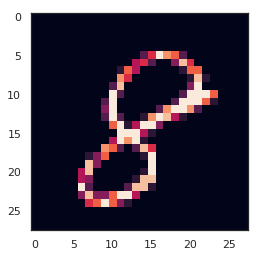

In [13]:
# Some examples
#https://techacademy.jp/magazine/20859
g = plt.imshow(X_train[0][:,:,0])

データ全部を使用する方法をバッチ学習、一部を使用する方法をミニバッチ学習、データを1つずつ使用する方法をオンライン学習と呼ぶ。ミニバッチ学習を使用することが一般的（らしいよ）。

データをシャッフルするかどうか設定する。現在のDatasetは0-9まできれいに並んで格納されているけど、訓練データに対してランダムな順番で学習を実行したい。そこで訓練データのDataLoaderはデータをシャッフルさせる。テストデータは正答率を求めるだけゆえ、シャッフルの必要はなし。

In [14]:
#データをPyTorchのTensorに変換
#ラベルのような整数データの場合はtorch.LongTensorを使用します。
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)
onehot_Ytrain = torch.LongTensor(onehot_Ytrain)
Y_val = torch.LongTensor(Y_val)
highlight=TensorDataset#torch.utils.data.TensorDataset
ds_train = TensorDataset(X_train, onehot_Ytrain)
#データとラベルをセットにしたDatasetを作成
#https://pytorch.org/docs/stable/data.html?
ds_test = TensorDataset(X_val, Y_val)

#データセットのミニバッチサイズを指定した、Dataloaderを作成
#バッチサイズとは、ニューラルネットワークの結合パラメータを学習する際に一度に使用するデータの数を決めます。
#https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
train_loader = DataLoader(ds_train,batch_size=64,shuffle=True)
test_loader = DataLoader(ds_test)

NameError: name 'TensorDataset' is not defined

In [15]:
from torch import nn
#全結合層(Full connected layer)と呼ばれている、
#すべてのノードが次の層のすべてのノードに繋がっている層の事です。（以下全結合層とします）

model = nn.Sequential()
model.add_module('fc1', nn.Linear(1,100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))
 
print(model)

Sequential(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 100)
        self.fc2 = nn.Linear(100, 34)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [17]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image, label = Variable(image), Variable(label)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(image), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))


def test():
    model.eval()

    for (image, label) in test_loader:
        image, label = Variable(image.float(), volatile=True), Variable(label)
        output = model(image)
        test_loss += criterion(output, label).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(label.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

#学習
for epoch in range(1, 1000 + 1):
    train(epoch)
    test()


NameError: name 'train_loader' is not defined